In [2]:
import csv
from urllib.request import urlretrieve, urlopen
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Available products
- water_level: Preliminary or verified water levels, depending on availability.
- air_temperature: Air temperature as measured at the station.
- water_temperature: Water temperature as measured at the station.
- wind: Wind speed, direction, and gusts as measured at the station.
- air_pressure: Barometric pressure as measured at the station.
- air_gap: Air Gap (distance between a bridge and the water's surface) at the station.
- conductivity: The water's conductivity as measured at the station.
- visibility: Visibility from the station's visibility sensor. A measure of atmospheric clarity.
- humidity: Relative humidity as measured at the station.
- salinity: Salinity and specific gravity data for the station.
- hourly_height: Verified hourly height water level data for the station.
- high_low: Verified high/low water level data for the station.
- daily_mean: Verified daily mean water level data for the station.
- monthly_mean: Verified monthly mean water level data for the station.
- one_minute_water_level: One minute water level data for the station.
- predictions: 6 minute predictions water level data for the station.
- datums: datums data for the stations.
currents

###  full api describe https://tidesandcurrents.noaa.gov/api/

In [3]:
# The website API only allow to get 31 days at a time
# so we loop the date and request for every month
def co_ops_data_more31d(file, day_i, day_e, station_id, product, units):
    dflist = []

    day1 = day_i
    day2 = day1 + timedelta(days=31)
    while (day2 < day_e):
        #print('Retrieving month %d of %d' % (day1.month, day1.year))
        dflist.append(co_ops_data(file, day1, day2, station_id, product, units))
        day1 = day2
        day2 += timedelta(days=31)

    # last months (or last part of month)
    if day2 > day_e:
        dflist.append(co_ops_data(file, day1, day_e, station_id, product, units))
    return pd.concat(dflist, ignore_index=True, copy=False)
    
def co_ops_data(file, day_i, day_e, station_id, product, units):
    url = 'https://tidesandcurrents.noaa.gov/api/datagetter?'
    url+= 'begin_date=' + day_i.strftime('%Y%m%d+%H:%M') + '&end_date=' + day_e.strftime('%Y%m%d+%H:%M') + '&station=' + station_id + '&product=' + product + '&units=' + units + '&time_zone=gmt&application=research&format=csv'
    urlretrieve(url, filename=file)
    df = pd.read_csv(file, parse_dates=['Date Time'], na_values='')
    df.rename(columns=lambda x: x.strip(), inplace=True)
    return df

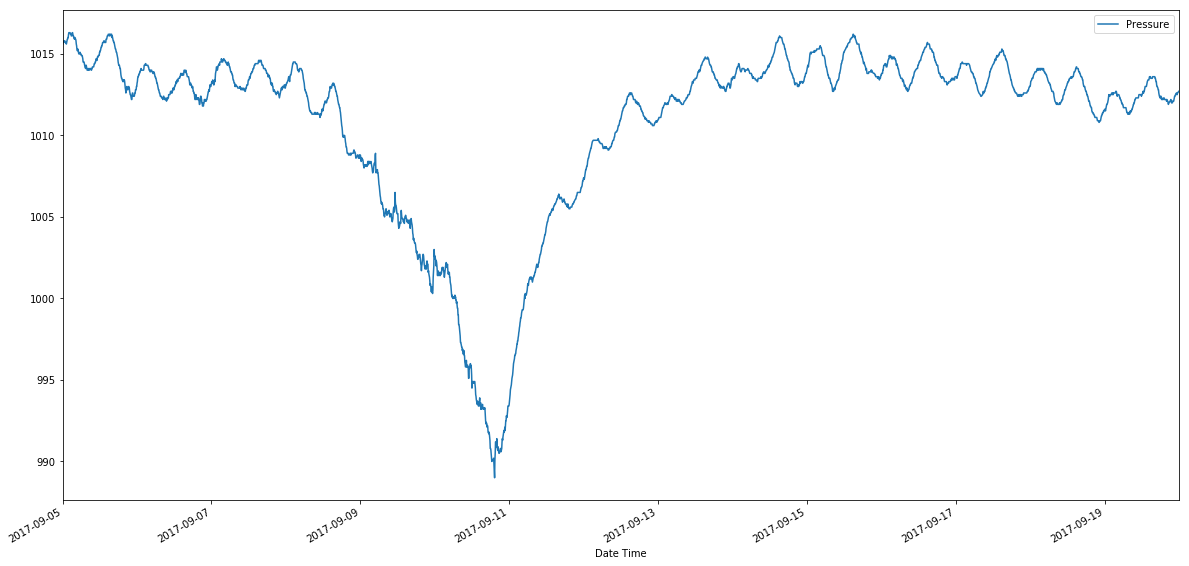

In [12]:
# general parameters
# University of Miami, RSMAS station (25°43.9' N, 80°9.7' W) (established on Jan 26, 1994)
station_id = '8723214' # https://tidesandcurrents.noaa.gov/stationhome.html?id=8723214
units = 'metric' # english, metric

# Hurricane Irma, Sept 10, 2017 in Miami
day_i = datetime(2017, 9, 5, 0, 0)
day_e = datetime(2017, 9, 20, 0, 0)

# Hurricane Wilma
#day_i = datetime(2005, 10, 1, 0, 0)
#day_e = datetime(2005, 10, 30, 0, 0)

# type of data
#product = 'water_level&datum=mllw' # for water level need to specify the datum reference
product = 'air_temperature' # °C or °F
#product = 'wind' # m/s or kn
#product = 'water_temperature' # °C or °F
product = 'air_pressure'

# only 31 days at the time
file = 'rsmas_weather/monthly_temp.csv'
if (day_e - day_i).days <= 0:
    print('Wrong date: end date should be greater then the begin date.')
elif (day_e - day_i).days > 31:
    df = co_ops_data_more31d(file, day_i, day_e, station_id, product, units)
else:
    df = co_ops_data(file, day_i, day_e, station_id, product, units)

if product == 'water_temperature':
    df.drop(['X', 'N', 'R'], axis=1, errors='ignore', inplace=True)
    df.dropna(axis=0, subset = ['Water Temperature'], how='any', inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.plot(figsize=(20,10), x='Date Time', y='Water Temperature', kind='line')
elif product == 'air_temperature':
    df.drop(['X', 'N', 'R'], axis=1, errors='ignore', inplace=True)
    df.dropna(axis=0, subset = ['Air Temperature'], how='any', inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.plot(figsize=(20,10), x='Date Time', y='Air Temperature', kind='line')
elif product == 'wind':
    df.drop(['Direction.1', 'X', 'R'], axis=1, errors='ignore', inplace=True)
    df.dropna(axis=0, subset = ['Speed'], how='any', inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.plot(figsize=(20,10), x='Date Time', y=['Speed', 'Gust'], kind='line') 
elif product == 'air_pressure':
    df.drop(['X', 'N', 'R'], axis=1, errors='ignore', inplace=True)
    df.dropna(axis=0, subset = ['Pressure'], how='any', inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.plot(figsize=(20,10), x='Date Time', y='Pressure', kind='line')

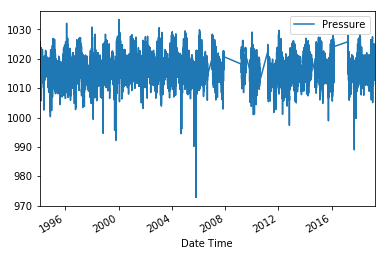

In [13]:
# Download data for the complete range of the RSMAS weather station (takes about 5min for each variables)
# get for each of the variables
# daily average, min, max, low, high
day_i = datetime(1994, 1, 1, 0, 0)
day_e = datetime(2019, 3, 19, 0, 0)

# type of data
#product = 'water_level&datum=mllw' # for water level need to specify the datum reference
#product = 'air_temperature'; varname = 'Air Temperature'
product = 'air_pressure'; varname = 'Pressure'
#product = 'wind'; varname = 'Speed' # Direction, Direction.1, Gust
#product = 'water_temperature'; varname = 'Water Temperature'

file = 'rsmas_weather/monthly_temp.csv'
file_full = 'rsmas_weather/complete_%s.csv' % product

if (day_e - day_i).days <= 0:
    print('Wrong date: end date should be greater then the begin date.')
elif (day_e - day_i).days > 31:
    df = co_ops_data_more31d(file, day_i, day_e, station_id, product, units)
else:
    df = co_ops_data(file, day_i, day_e, station_id, product, units)

# Temperature
# drop non useful columns and NaN values
df.drop(['X', 'N', 'R'], axis=1, errors='ignore', inplace=True)
df.dropna(axis=0, how='any', inplace=True)
df.reset_index(drop=True, inplace=True)

# 2006-09-07/08 has wrong values of ~5°C and then the sensor wasn't operating until 2007-01-04 for one day and then restarted in 2009-03-19
wrong_index = np.where(np.logical_and(df['Date Time'] >= pd.Timestamp('2006-09-07 00:00:00'), df['Date Time'] <= pd.Timestamp('2007-01-05 00:00:00')))[0]
df.drop(wrong_index, inplace=True)
df.reset_index(drop=True, inplace=True)

# plot the complete dataset
df.plot(x='Date Time', y=varname, kind='line')

# export Water Temperature to CSV
df.to_csv(file_full, sep=',', index=False)

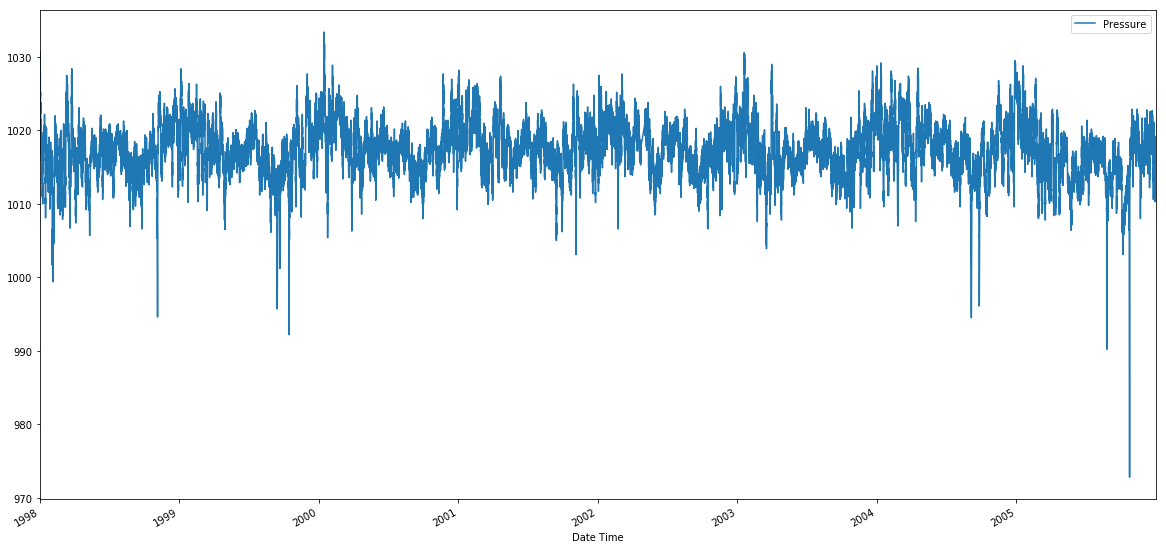

In [38]:
# find period without gap (8 years)
index1 = (df['Date Time'] > pd.Timestamp('1998-01-01')).values.argmax()
index2 = (df['Date Time'] < pd.Timestamp('2006-01-01')).values.argmin()
df[index1:index2].plot(figsize=(20,10), x='Date Time', y='Pressure', kind='line')

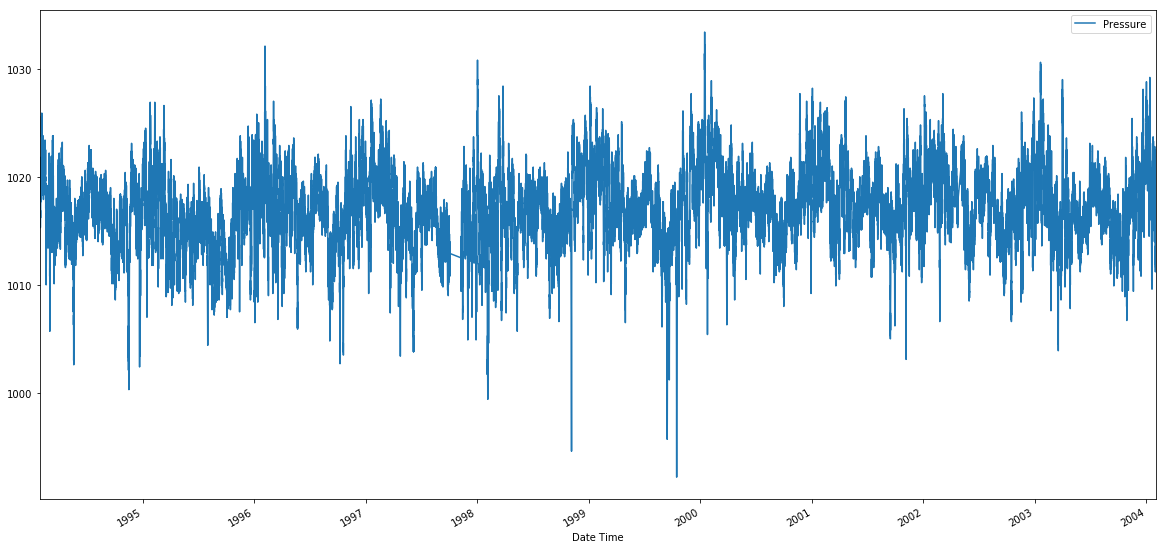

In [14]:
# plot the first 10 years of data
index = (df['Date Time'] < pd.Timestamp('2004-02-01')).values.argmin()
df[:index].plot(figsize=(20,10), x='Date Time', y='Pressure', kind='line')

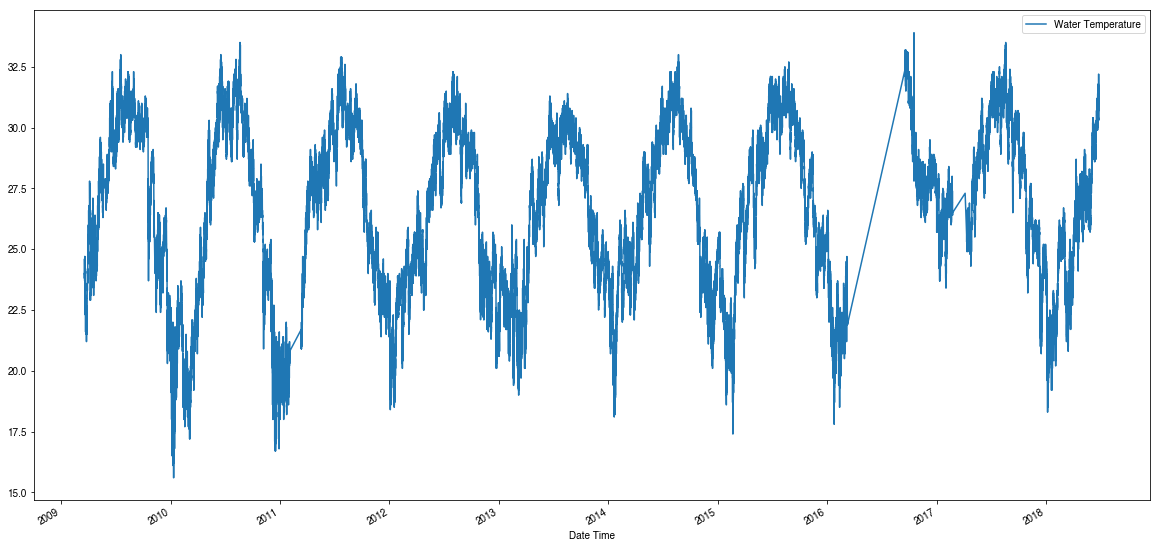

In [153]:
# plot the last 10 years of data
index = (df['Date Time'] < pd.Timestamp('2008-01-01')).values.argmin()
df[index:].plot(figsize=(20,10), x='Date Time', y='Water Temperature', kind='line')

In [ ]:
# TODO

# load pandas from complete_water.csv file
water_full = 'rsmas_weather/complete_water_temp.csv'
df = pd.read_csv(water_full, parse_dates=['Date Time'])
df.set_index('Date Time', inplace=True)

# function get the first and last day in the saved csv
first_date = df.index.min()
last_date = df.index.max()
print('Database is from %s to %s' % (first_date, last_date))

# to show basic stats df.describe()
df.describe()

In [155]:
yearly_avg = df.groupby(lambda x : x.year).mean()
monthly_avg = df.groupby(lambda x : x.month).mean()

col_names = ['avg', 'avg_min', 'avg_max', 'min', 'max']
daily  = pd.DataFrame(columns = col_names)
monthly  = pd.DataFrame(columns = col_names)
yearly  = pd.DataFrame(columns = col_names)

# daily minimum and maximum values used for min/max avg calculation
date_min = df.groupby(lambda x : x.date).min()
date_max = df.groupby(lambda x : x.date).max()
# for some reason the date is not a datetime object after groupby..
date_min.index = pd.to_datetime(date_min.index)
date_max.index = pd.to_datetime(date_max.index)

# evaluate the climatology
daily['avg'] = df.groupby(lambda x : x.dayofyear).mean()['Water Temperature']
daily['min'] = df.groupby(lambda x : x.dayofyear).min()['Water Temperature']
daily['max'] = df.groupby(lambda x : x.dayofyear).max()['Water Temperature']
daily['avg_min'] = date_min.groupby(lambda x : x.dayofyear).mean()['Water Temperature']
daily['avg_max'] = date_max.groupby(lambda x : x.dayofyear).mean()['Water Temperature']

monthly['avg'] = df.groupby(lambda x : x.month).mean()['Water Temperature']
monthly['min'] = df.groupby(lambda x : x.month).min()['Water Temperature']
monthly['max'] = df.groupby(lambda x : x.month).max()['Water Temperature']
monthly['avg_min'] = date_min.groupby(lambda x : x.month).mean()['Water Temperature']
monthly['avg_max'] = date_max.groupby(lambda x : x.month).mean()['Water Temperature']

yearly['avg'] = df.groupby(lambda x : x.year).mean()['Water Temperature']
yearly['min'] = df.groupby(lambda x : x.year).min()['Water Temperature']
yearly['max'] = df.groupby(lambda x : x.year).max()['Water Temperature']
yearly['avg_min'] = date_min.groupby(lambda x : x.year).mean()['Water Temperature']
yearly['avg_max'] = date_max.groupby(lambda x : x.year).mean()['Water Temperature']

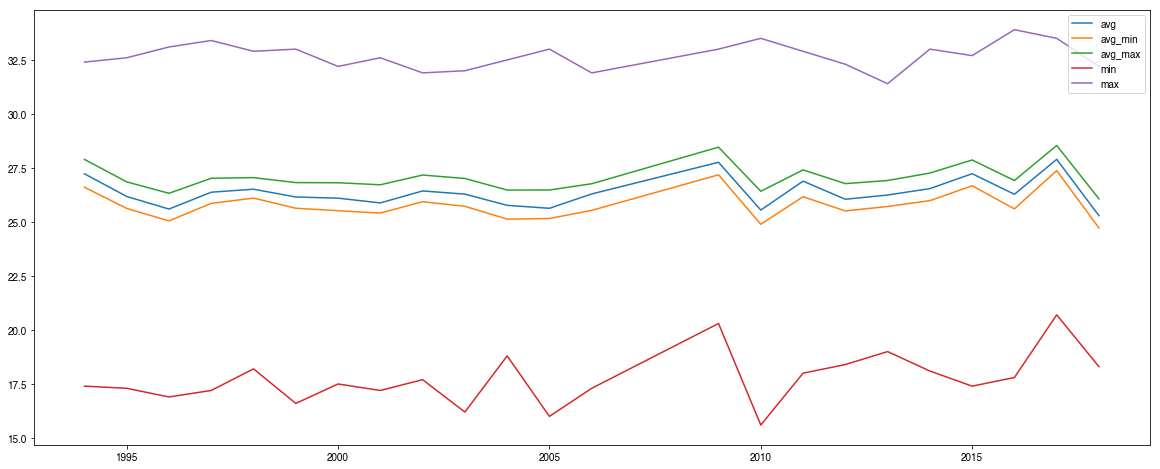

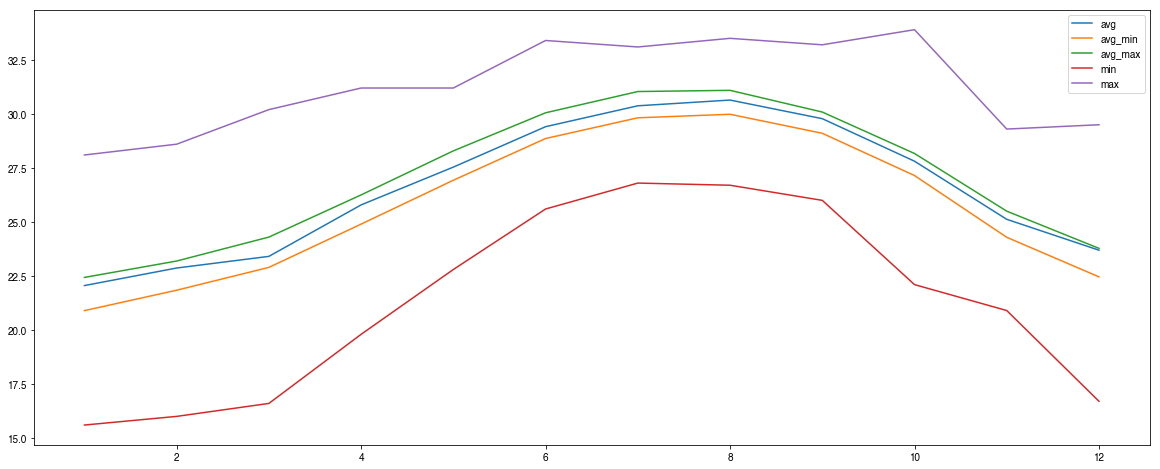

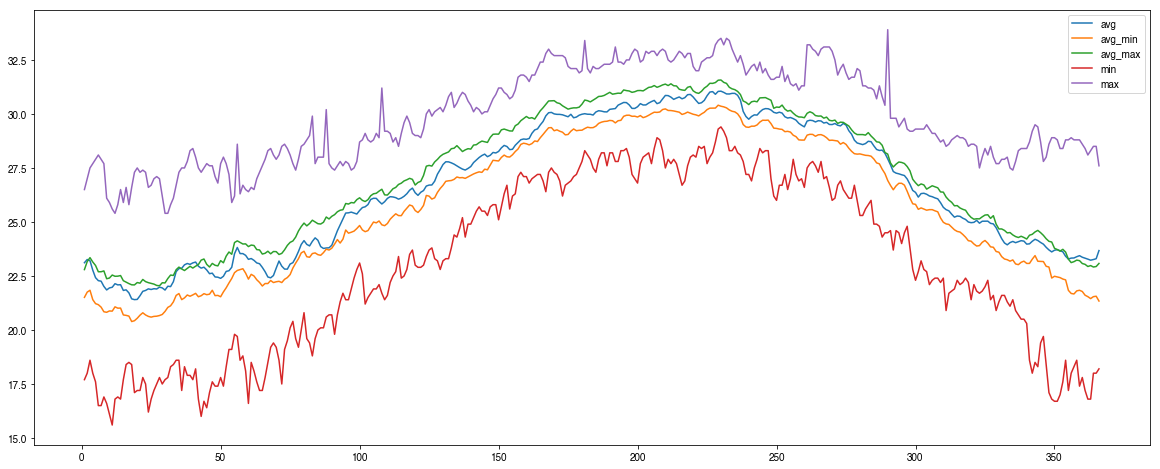

In [156]:
# plot the daily, monthly and yearly climatology
yearly.plot(figsize=(20,8), y=['avg', 'avg_min', 'avg_max', 'min', 'max'], kind='line')
monthly.plot(figsize=(20,8), y=['avg', 'avg_min', 'avg_max', 'min', 'max'], kind='line')
daily.plot(figsize=(20,8), y=['avg', 'avg_min', 'avg_max', 'min', 'max'], kind='line')

In [157]:
# function to download the missing data
# 1. look the last day in the file
# 2. download last_day + 1 until today-1
# 3. load CSV into a dataframe and append the latest data
# 4. save back to CSV file